In [1]:
import math
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
import pandas as pd
import time
import mpmath
import os
import importlib
import importlib
import FVMF
importlib.reload(FVMF)
import test_ensemble
importlib.reload(test_ensemble)
import matplotlib.pyplot as plt

# define the parameters
BATCH_SIZE = 100
TEST_BATCH_SIZE = 100
COND_OPT = False
CLASSES = 10
# TRAIN_EPOCHS = 250
SAMPLES = 1
TEST_SAMPLES = 10
TEMPER = 0.001
TEMPER_PRIOR = 0.001
pepochs = 50


DEVICE = torch.device("cuda:1")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
cuda = torch.cuda.set_device(1)


#d_CIFAR_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
#d_CIFAR_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

#print(transforms.ToTensor(cifar_train))
#print(dtrain[0].shape)

#Ok so this is actually not trivial... Maybe we need to place a convulutional layer first in order to properly parse this into
#our vMF so that we don't lose the positionality of our data?

GPUs are used!
FVMF RELOADED
GPUs are used!
FVMF RELOADED


In [2]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        './mnist', train=True, download=True,
        transform=transforms.ToTensor()),
    batch_size=6000, shuffle=True, **LOADER_KWARGS)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        './mnist', train=False, download=True,
        transform=transforms.ToTensor()),
    batch_size=10000, shuffle=False, **LOADER_KWARGS)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

for batch_idx, (data, target) in enumerate(train_loader):
    train_data, train_target = data.to(DEVICE), target.to(DEVICE)
#print(train_data.shape)

for batch_idx, (data, target) in enumerate(test_loader):
    test_data, test_target = data.to(DEVICE), target.to(DEVICE)
#test_data = torch.cat

#dtrain Må pakke den inn i en dimensjon... kanskje?

In [3]:
print(train_data.shape,test_data.shape)
print(train_target.shape,test_target.shape)

dtrain = torch.flatten(train_data, start_dim=1, end_dim= -1)
#print(dtrain.shape)

dtest = torch.flatten(test_data, start_dim=1, end_dim= -1)
#print(dtest.shape)

#print(train_target.shape)
#dtrain = torch.cat((dtrain,train_target), dim = 0)

train_target1 = torch.reshape(train_target,(6000, 1))
#print(train_target1.shape)

dtrain = torch.cat((dtrain,train_target1), dim = 1).numpy(force=True)
print(dtrain.shape)

test_target1 = torch.reshape(test_target,(10000, 1))
#print(test_target1.shape)

dtest = torch.cat((dtest,test_target1), dim = 1).numpy(force=True)
print(dtest.shape)

torch.Size([6000, 1, 28, 28]) torch.Size([10000, 1, 28, 28])
torch.Size([6000]) torch.Size([10000])
(6000, 785)
(10000, 785)


In [4]:
l1shape=(784,10)
l2shape=(10, 10)
l3shape=(10, 10)
#l4shape=(10, 10)
#layershapes = [l1shape, l2shape, l3shape, l4shape]
layershapes = [l1shape, l2shape, l3shape]
data_shape = (0,784,784,785)

In [5]:
norm_w_mu_layer1 = []

import math
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
import pandas as pd
import time
import mpmath
import os
import importlib
import matplotlib.pyplot as plt

import test_ensemble
importlib.reload(test_ensemble)
import FVMF
importlib.reload(FVMF)

trtimes  = []

epochs =10

for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net5= FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='Gaussian',
                                #b_kappa=torch.Tensor(1).uniform_(3,3.1),
                                #w_kappa=torch.Tensor(1).uniform_(5,5.1),
                                Temper = 0.1,
                                classification = 'classification',VISION = 'dense')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net5.parameters(), lr=0.0007)
    
    
    for epoch in range(epochs):
        train = FVMF.train(net5, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,
                                    shape = data_shape,CLASSES = CLASSES)    
        trtimes.append(train[1].detach().cpu().numpy())
        #print('max:',net4.weight_mu[1].max())
        norm = 0
        for i in net5.weight_mu:
            norm+=torch.norm(i)
        #norm = norm/len(net5.weight_mu)
        norm_w_mu_layer1.append(norm.detach().cpu().numpy()/len(net5.weight_mu))

    res = test_ensemble.test_ensemble(net5,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,TEST_BATCH_SIZE,
                                      CLASSES=CLASSES,DEVICE=DEVICE,shape = data_shape,plot = True)
    print('Gaussian 10 epoch')
    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

GPUs are used!
FVMF RELOADED
0
Random Init Utilized
oui


/opt/uio/modules/rhel8/easybuild/software/Miniconda3/lmsunde/envs/BNN2/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


1
loss: tensor(218.2379, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(216.7922, device='cuda:1', grad_fn=<NllLossBackward0>)
2
loss: tensor(178.5266, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(177.0838, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(140.5725, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(139.1331, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(109.2831, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(107.8393, device='cuda:1', grad_fn=<NllLossBackward0>)
5
loss: tensor(89.5815, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(88.1566, device='cuda:1', grad_fn=<NllLossBackward0>)
6
loss: tensor(75.3794, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(73.9095, device='cuda:1', grad_fn=<NllLossBackward0>)
7
loss: tensor(69.9300, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likeliho

In [6]:
epochs = 20


for epoch in range(epochs):
    train = FVMF.train(net5, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,
                                shape = data_shape,CLASSES = CLASSES)    
    trtimes.append(train[1].detach().cpu().numpy())
    norm = 0
    for i in net5.weight_mu:
        norm+=torch.norm(i)
    #norm = norm/len(net5.weight_mu)
    norm_w_mu_layer1.append(norm.detach().cpu().numpy()/len(net5.weight_mu))
#print('norm:',torch.norm(net4.weight_mu[1]))

res = test_ensemble.test_ensemble(net5,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,TEST_BATCH_SIZE,
                                  CLASSES,DEVICE,shape = data_shape,plot = True)
print('Gaussian 30 epoch')

1
loss: tensor(55.2295, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(55.2295, device='cuda:1', grad_fn=<NllLossBackward0>)
2
loss: tensor(52.3668, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(52.3668, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(51.0710, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(51.0710, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(50.7007, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(50.7007, device='cuda:1', grad_fn=<NllLossBackward0>)
5
loss: tensor(50.2574, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(50.2574, device='cuda:1', grad_fn=<NllLossBackward0>)
6
loss: tensor(51.9017, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(51.9017, device='cuda:1', grad_fn=<NllLossBackward0>)
7
loss: tensor(47.9520, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tens

In [7]:
epochs = 20

for epoch in range(epochs):
    train = FVMF.train(net5, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,
                                shape = data_shape,CLASSES = CLASSES)    
    trtimes.append(train[1].detach().cpu().numpy())
    #print('max:',net4.weight_mu[1].max())
    norm = 0
    for i in net5.weight_mu:
        norm+=torch.norm(i)
    #norm = norm/len(net5.weight_mu)
    norm_w_mu_layer1.append(norm.detach().cpu().numpy()/len(net5.weight_mu))
    
res = test_ensemble.test_ensemble(net5,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,TEST_BATCH_SIZE,
                                  CLASSES,DEVICE,shape = data_shape,plot = True)
print('Gaussian 50 epoch')

1
loss: tensor(41.6848, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(41.6848, device='cuda:1', grad_fn=<NllLossBackward0>)
2
loss: tensor(43.8790, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(43.8790, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(41.4056, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(41.4056, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(43.2392, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(43.2392, device='cuda:1', grad_fn=<NllLossBackward0>)
5
loss: tensor(40.6603, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(40.6603, device='cuda:1', grad_fn=<NllLossBackward0>)
6
loss: tensor(41.6727, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(41.6727, device='cuda:1', grad_fn=<NllLossBackward0>)
7
loss: tensor(40.8051, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tens

Gaussian loss curve, 50 epoch Vision


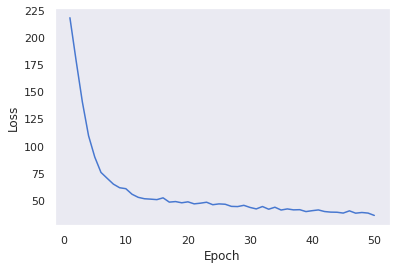

In [8]:
x = []
for i in range(50):
    x.append(i+1)
print('Gaussian loss curve, 50 epoch Vision')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x,trtimes)
plt.savefig('Plots/Gaussian_loss_50_epoch_Vision.png', dpi=250)
plt.show()

Gaussian weight average mu norm per epoch


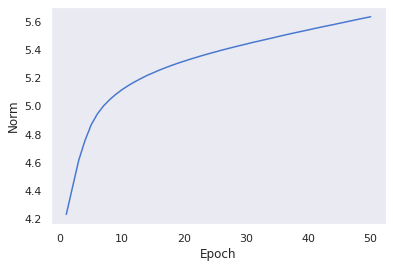

In [9]:
x = []
for i in range(50):
    x.append(i+1)
print('Gaussian weight average mu norm per epoch')
plt.xlabel('Epoch')
plt.ylabel('Norm')
plt.plot(x,norm_w_mu_layer1)
plt.savefig('Plots/Gaussian_norm_50_epoch_Vision.png', dpi=250)
plt.show()

In [10]:
norm_w_mu_layer1 = []
trtimes  = []
epochs = 30

#Note, for this regression task, the last 7 to 1 layer has a Gaussian VD, where we kill the prior and simply optimize with MLE.
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    vMFRegression30= FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(3,3.1),
                                w_kappa=torch.Tensor(1).uniform_(6.5,6.6),
                                Temper = 0,classification = 'classification',VISION = 'dense')
    
    #for j,p in enumerate(net2.l1.parameters()):
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(vMFRegression30.parameters(), lr=0.08)
    
    
    for epoch in range(epochs):
        train = FVMF.train(vMFRegression30, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,
                                    shape = data_shape,CLASSES = CLASSES)    
        trtimes.append(train[1].detach().cpu().numpy())
        #print('max:',vMFRegression30.weight_mu[1].max())
        norm = 0
        for i in vMFRegression30.weight_mu:
            norm+=torch.norm(i)
        #norm = norm/len(net5.weight_mu)
        norm_w_mu_layer1.append(norm.detach().cpu().numpy()/len(vMFRegression30.weight_mu))
    res = test_ensemble.test_ensemble(vMFRegression30,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,TEST_BATCH_SIZE,
                                      CLASSES,DEVICE,shape = data_shape,plot = True)
    print('vMF 30 epoch')

0
Random Init Utilized
oui
1
loss: tensor(203.8893, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(203.8893, device='cuda:1', grad_fn=<NllLossBackward0>)
2
loss: tensor(183.8629, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(183.8629, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(145.6111, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(145.6111, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(117.9550, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(117.9550, device='cuda:1', grad_fn=<NllLossBackward0>)
5
loss: tensor(100.7812, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(100.7812, device='cuda:1', grad_fn=<NllLossBackward0>)
6
loss: tensor(93.1621, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(93.1621, device='cuda:1', grad_fn=<NllLossBackward0>)
7
loss: tensor(94.1622, device='cuda:1', grad_fn=<AddBack

In [11]:
epochs = 20


for epoch in range(epochs):
    train = FVMF.train(vMFRegression30, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,
                                shape = data_shape,CLASSES = CLASSES)    
    trtimes.append(train[1].detach().cpu().numpy())
    #print('max:',vMFRegression30.weight_mu[1].max())
    norm = 0
    for i in vMFRegression30.weight_mu:
        norm+=torch.norm(i)
    #norm = norm/len(net5.weight_mu)
    norm_w_mu_layer1.append(norm.detach().cpu().numpy()/len(vMFRegression30.weight_mu))
res = test_ensemble.test_ensemble(vMFRegression30,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,TEST_BATCH_SIZE,
                                  CLASSES,DEVICE,shape = data_shape,plot = True)
print('vMF 50 epoch')

1
loss: tensor(73.9860, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(73.9860, device='cuda:1', grad_fn=<NllLossBackward0>)
2
loss: tensor(37.4445, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(37.4445, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(42.5648, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(42.5648, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(44.0098, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(44.0098, device='cuda:1', grad_fn=<NllLossBackward0>)
5
loss: tensor(48.0156, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(48.0156, device='cuda:1', grad_fn=<NllLossBackward0>)
6
loss: tensor(40.1919, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(40.1919, device='cuda:1', grad_fn=<NllLossBackward0>)
7
loss: tensor(46.7626, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tens

/uio/hume/student-u44/lmsunde/projects/BNN/test_ensemble.py:17: RuntimeWarning: overflow encountered in exp
  return (1 / (1 + np.exp(-x)))


Component 0 Accuracy: 8533.0/10000
Component 1 Accuracy: 8563.0/10000
Component 2 Accuracy: 8524.0/10000
Component 3 Accuracy: 8509.0/10000
Component 4 Accuracy: 8504.0/10000
Component 5 Accuracy: 8521.0/10000
Component 6 Accuracy: 8507.0/10000
Component 7 Accuracy: 8509.0/10000
Component 8 Accuracy: 8540.0/10000
Component 9 Accuracy: 8511.0/10000
Posterior Mean Accuracy: 8627.0/10000
Ensemble Accuracy: 8630/10000
vMF 50 epoch


vMF loss curve, 50 epoch regression


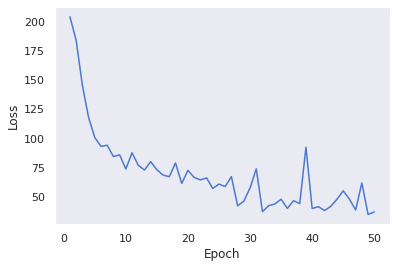

In [12]:
x = []
for i in range(50):
    x.append(i+1)
print('vMF loss curve, 50 epoch regression')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x,trtimes)
plt.savefig('Plots/vMF_loss_50_epoch_Vision.png', dpi=250)
plt.show()

vMF weight mu average norm per epoch


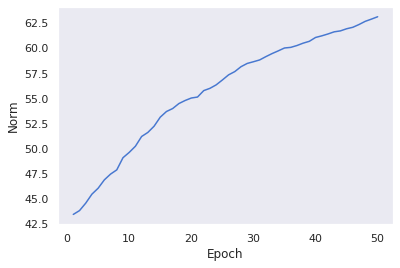

In [13]:
x = []
for i in range(50):
    x.append(i+1)
print('vMF weight mu average norm per epoch')
plt.xlabel('Epoch')
plt.ylabel('Norm')
plt.plot(x,norm_w_mu_layer1)
plt.savefig('Plots/vMF_norm_50_epoch_Vision.png', dpi=250)
plt.show()

In [14]:
norm_w_mu_layer1 = []

import math
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
import pandas as pd
import time
import mpmath
import os
import importlib
import matplotlib.pyplot as plt

# define the parameters
BATCH_SIZE = 100
TEST_BATCH_SIZE = 100
COND_OPT = False
CLASSES = 10
# TRAIN_EPOCHS = 250
SAMPLES = 1
TEST_SAMPLES = 10
TEMPER = 0.001
TEMPER_PRIOR = 0.001
pepochs = 50

import test_ensemble
importlib.reload(test_ensemble)
import FVMF
importlib.reload(FVMF)

epochs = 10
trtimes = []


for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    vMFRegression= FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(3,3.1),
                                w_kappa=torch.Tensor(1).uniform_(6.5,6.6),
                                Temper = 0,classification = 'classification',VISION = 'dense',NODEFORCE =False)
    
    #for j,p in enumerate(net2.l1.parameters()):
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(vMFRegression.parameters(), lr=0.10) #0.11
    
    
    for epoch in range(epochs):
        train = FVMF.train(vMFRegression, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,
                                    shape = data_shape,CLASSES = CLASSES)    
        trtimes.append(train[1].detach().cpu().numpy())
        #print('max:',vMFRegression.weight_mu[1].max())
        norm = 0
        for i in vMFRegression.weight_mu:
            norm+=torch.norm(i)
        #norm = norm/len(net5.weight_mu)
        norm_w_mu_layer1.append(norm.detach().cpu().numpy()/len(vMFRegression.weight_mu))
    res = test_ensemble.test_ensemble(vMFRegression,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,TEST_BATCH_SIZE,
                                      CLASSES,DEVICE,shape = data_shape,plot = True)
    print('vMF 10 epoch')
    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

GC_intensity = 1

#Kanskje er det en god idee å også arve kappaene, men halvere dem? Hva om vi også kjører på med litt normalizering av mu-ene her?
#Hva med adaptiv kappa per lag? Det er jo bare en kappa per bias-lag. GC fungerer rett og slett ikke.

w_mu_R = []
for i in range(len(vMFRegression.weight_mu)):
    #print('\n','torch.norm(net4.weight_mu[i]):',torch.norm(net4.weight_mu[i]))
    w_mu_R.append(vMFRegression.weight_mu[i]/torch.norm(vMFRegression.weight_mu[i]))
    #print('\n','norm w_mu[i]',torch.norm(w_mu[i]))
    
b_mu_R = []
for i in range(len(vMFRegression.bias_mu)):
    #print('\n','torch.norm(net4.bais_mu[i]):',torch.norm(net4.bias_mu[i]))
    b_mu_R.append(vMFRegression.bias_mu[i]/torch.norm(vMFRegression.bias_mu[i]))
    #print('\n','norm b_mu[i]',torch.norm(b_mu[i]))
    
b_rho_R= []
for i in range(len(vMFRegression.bias_rho)):
    b_rho_R.append(vMFRegression.bias_rho[i])

w_rho_R= []
for i in range(len(vMFRegression.weight_rho)):
    w_rho_R.append(vMFRegression.weight_rho[i])
#For some reason, it seems that the weights are not being properly normalized here. no actually they are, but the norm reported is the norm after 1 optimization step.

epochs = 20
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    vMFRegression2= FVMF.BayesianNetwork(w_mu = w_mu_R, b_mu = b_mu_R, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa= b_rho_R, #torch.Tensor(1).uniform_(1.0,3.1), 
                                w_kappa= w_rho_R, #torch.Tensor(1).uniform_(2.0,4.1), 
                                Temper = 0,classification = 'classification',VISION = 'dense')
    
    
    optimizer = optim.Adam(vMFRegression2.parameters(), lr=0.025) #0.01 9727 acc
    
    
    for epoch in range(epochs):
        train = FVMF.train(vMFRegression2, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,
                                    shape = data_shape,CLASSES = CLASSES)    
        trtimes.append(train[1].detach().cpu().numpy())
        print('max:',vMFRegression2.weight_mu[1].max())
        norm = 0
        for i in vMFRegression2.weight_mu:
            norm+=torch.norm(i)
        #norm = norm/len(net5.weight_mu)
        norm_w_mu_layer1.append(norm.detach().cpu().numpy()/len(vMFRegression2.weight_mu))

    res = test_ensemble.test_ensemble(vMFRegression2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,TEST_BATCH_SIZE,
                                      CLASSES,DEVICE,shape = data_shape,plot = True)
    print('vMF 10+20 epoch NII')

#Kanskje er det en god idee å også arve kappaene, men halvere dem? Hva om vi også kjører på med litt normalizering av mu-ene her?
#Hva med adaptiv kappa per lag? Det er jo bare en kappa per bias-lag. GC fungerer rett og slett ikke.

GPUs are used!
FVMF RELOADED
0
Random Init Utilized
oui
1
loss: tensor(199.4798, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(199.4798, device='cuda:1', grad_fn=<NllLossBackward0>)
2
loss: tensor(164.7282, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(164.7282, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(137.8903, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(137.8903, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(119.9077, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(119.9077, device='cuda:1', grad_fn=<NllLossBackward0>)
5
loss: tensor(90.8144, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(90.8144, device='cuda:1', grad_fn=<NllLossBackward0>)
6
loss: tensor(82.2058, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(82.2058, device='cuda:1', grad_fn=<NllLossBackward0>)
7
loss: tensor(92.0179, device

In [15]:
w_mu_R = []
for i in range(len(vMFRegression2.weight_mu)):
    #print('\n','torch.norm(net4.weight_mu[i]):',torch.norm(net4.weight_mu[i]))
    w_mu_R.append(vMFRegression2.weight_mu[i]/torch.norm(vMFRegression2.weight_mu[i]))
    #print('\n','norm w_mu[i]',torch.norm(w_mu[i]))
    
b_mu_R = []
for i in range(len(vMFRegression2.bias_mu)):
    #print('\n','torch.norm(net4.bais_mu[i]):',torch.norm(net4.bias_mu[i]))
    b_mu_R.append(vMFRegression2.bias_mu[i]/torch.norm(vMFRegression2.bias_mu[i]))
    #print('\n','norm b_mu[i]',torch.norm(b_mu[i]))
    
b_rho_R= []
for i in range(len(vMFRegression2.bias_rho)):
    b_rho_R.append(vMFRegression2.bias_rho[i])

w_rho_R= []
for i in range(len(vMFRegression2.weight_rho)):
    w_rho_R.append(vMFRegression2.weight_rho[i])
#For some reason, it seems that the weights are not being properly normalized here. no actually they are, but the norm reported is the norm after 1 optimization step.

epochs = 20
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    vMFRegression3= FVMF.BayesianNetwork(w_mu = w_mu_R, b_mu = b_mu_R, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa= b_rho_R, #torch.Tensor(1).uniform_(1.0,3.1), 
                                w_kappa= w_rho_R, #torch.Tensor(1).uniform_(2.0,4.1), 
                                Temper = 0,classification = 'classification',VISION = 'dense')
    
    #for j,p in enumerate(net2.l1.parameters()):
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(vMFRegression3.parameters(), lr=0.01) #0.01 9083/10000 acc
    
    
    for epoch in range(epochs):
        train = FVMF.train(vMFRegression3, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,
                                    shape = data_shape,CLASSES = CLASSES)
        trtimes.append(train[1].detach().cpu().numpy())
        #print('max:',vMFRegression3.weight_mu[1].max())
        norm = 0
        for i in vMFRegression3.weight_mu:
            norm+=torch.norm(i)
        #norm = norm/len(net5.weight_mu)
        norm_w_mu_layer1.append(norm.detach().cpu().numpy()/len(vMFRegression3.weight_mu))
    res = test_ensemble.test_ensemble(vMFRegression3,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,TEST_BATCH_SIZE,
                                      CLASSES,DEVICE,shape = data_shape,plot = True)
    print('vMF 10+20+20 epoch NII')

0
oui
1
loss: tensor(49.1273, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(49.1273, device='cuda:1', grad_fn=<NllLossBackward0>)
2
loss: tensor(41.2474, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(41.2474, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(39.8231, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(39.8231, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(41.9922, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(41.9922, device='cuda:1', grad_fn=<NllLossBackward0>)
5
loss: tensor(37.0336, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(37.0336, device='cuda:1', grad_fn=<NllLossBackward0>)
6
loss: tensor(34.2659, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(34.2659, device='cuda:1', grad_fn=<NllLossBackward0>)
7
loss: tensor(28.5382, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood

NIIvMF loss curve, 50 epoch Vision


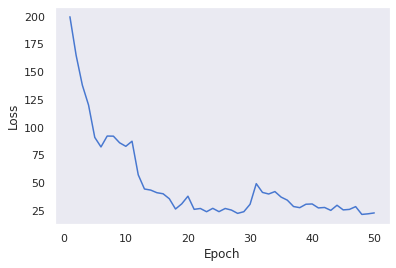

In [16]:
x = []
for i in range(50):
    x.append(i+1)
print('NIIvMF loss curve, 50 epoch Vision')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x,trtimes)
plt.savefig('Plots/NIIvMF_loss_50_epoch_Vision.png', dpi=250)
plt.show()

NIIvMF weight mu average norm per epoch Vision


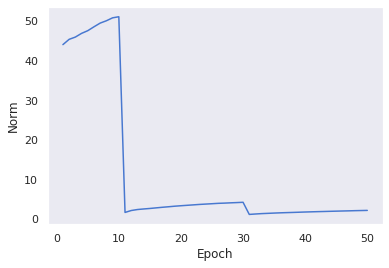

In [17]:
x = []
for i in range(50):
    x.append(i+1)
print('NIIvMF weight mu average norm per epoch Vision')
plt.xlabel('Epoch')
plt.ylabel('Norm')
plt.plot(x,norm_w_mu_layer1)
plt.savefig('Plots/NIIvMF_norm_50_epoch_Vision.png', dpi=250)
plt.show()

In [18]:
r"""
epochs = 10
trtimes  = []
# make inference on 10 networks
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net = FVMF.BayesianNetwork(layershapes=layershapes,BN='notbatchnorm',VD='Gaussian',
                               dtrain=dtrain,dtest=dtest,BATCH_SIZE = 100,classification = 'classification',VISION = 'dense').to(DEVICE)
    #net = VMF.BayesianNetwork(l1=l1shape, l2=l2shape, l3=l3shape,l4=l4shape,BN='notbatchnorm').to(DEVICE)
    optimizer = optim.Adam(net.parameters(), lr=0.007)
    for epoch in range(epochs):

        train = FVMF.train(net, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape,CLASSES = CLASSES)
        trtimes.append(train[1].detach().cpu().numpy())
        #print(net.l1.weight_mu.mean())

    res = test_ensemble.test_ensemble(net,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")


x = []
for i in range(epochs):
    x.append(i+1)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Gaussian loss, 10 epoch MNIST classification with half the trainingset')
plt.plot(x,trtimes)
#plt.savefig('Plots/Gaussian_loss_10_epoch_MNIST_VISION.png')
plt.show()
"""

'\nepochs = 10\ntrtimes  = []\n# make inference on 10 networks\nfor i in range(0, 1):\n    print(i)\n    torch.manual_seed(i)\n    net = FVMF.BayesianNetwork(layershapes=layershapes,BN=\'notbatchnorm\',VD=\'Gaussian\',\n                               dtrain=dtrain,dtest=dtest,BATCH_SIZE = 100,classification = \'classification\',VISION = \'dense\').to(DEVICE)\n    #net = VMF.BayesianNetwork(l1=l1shape, l2=l2shape, l3=l3shape,l4=l4shape,BN=\'notbatchnorm\').to(DEVICE)\n    optimizer = optim.Adam(net.parameters(), lr=0.007)\n    for epoch in range(epochs):\n\n        train = FVMF.train(net, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape,CLASSES = CLASSES)\n        trtimes.append(train[1].detach().cpu().numpy())\n        #print(net.l1.weight_mu.mean())\n\n    res = test_ensemble.test_ensemble(net,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)\n\n    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")\n\n\nx = [

In [19]:
r"""
epochs = 20
for epoch in range(epochs):

    train = FVMF.train(net, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape,CLASSES = CLASSES)
    trtimes.append(train[1].detach().cpu().numpy())
    #print(net.l1.weight_mu.mean())


for i in range(epochs):
    x.append(10+epochs)
res = test_ensemble.test_ensemble(net,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Gaussian loss, 30 epoch MNIST classification with half the trainingset')
plt.plot(x,trtimes)
#plt.savefig('Plots/Gaussian_loss_30_epoch_MNIST_VISION.png')
plt.show()
"""

"\nepochs = 20\nfor epoch in range(epochs):\n\n    train = FVMF.train(net, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape,CLASSES = CLASSES)\n    trtimes.append(train[1].detach().cpu().numpy())\n    #print(net.l1.weight_mu.mean())\n\n\nfor i in range(epochs):\n    x.append(10+epochs)\nres = test_ensemble.test_ensemble(net,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)\nplt.xlabel('Epoch')\nplt.ylabel('Loss')\nplt.title('Gaussian loss, 30 epoch MNIST classification with half the trainingset')\nplt.plot(x,trtimes)\n#plt.savefig('Plots/Gaussian_loss_30_epoch_MNIST_VISION.png')\nplt.show()\n"

In [20]:
r"""
epochs = 20
for epoch in range(epochs):

    train = FVMF.train(net, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape,CLASSES = CLASSES)
    trtimes.append(train[1].detach().cpu().numpy())
    #print(net.l1.weight_mu.mean())

res = test_ensemble.test_ensemble(net,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

"""

'\nepochs = 20\nfor epoch in range(epochs):\n\n    train = FVMF.train(net, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape,CLASSES = CLASSES)\n    trtimes.append(train[1].detach().cpu().numpy())\n    #print(net.l1.weight_mu.mean())\n\nres = test_ensemble.test_ensemble(net,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)\n\n'

In [21]:
r"""
for i in range(epochs):
    x.append(30+1)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Gaussian loss, 50 epoch MNIST classification with half the trainingset')
plt.plot(x,trtimes)
#plt.savefig('Plots/Gaussian_loss_50_epoch_MNIST_VISION__.png')
plt.show()
"""

"\nfor i in range(epochs):\n    x.append(30+1)\n\nplt.xlabel('Epoch')\nplt.ylabel('Loss')\nplt.title('Gaussian loss, 50 epoch MNIST classification with half the trainingset')\nplt.plot(x,trtimes)\n#plt.savefig('Plots/Gaussian_loss_50_epoch_MNIST_VISION__.png')\nplt.show()\n"

In [22]:
r"""
importlib.reload(FVMF)
epochs = 10
trtimes = []
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net2 = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(4,4.1),
                                w_kappa=torch.Tensor(1).uniform_(6.5,6.6),
                                Temper = 1, normalize = 'No',classification = 'classification',VISION = 'dense')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #p.requires_grad_(False)
    
    #for j,p in enumerate(net2.l2.parameters()):
    #p.requires_grad_(False)
    
    optimizer = optim.Adam(net2.parameters(), lr=0.08)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net2, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape,CLASSES = CLASSES)
        trtimes.append(train[1].detach().cpu().numpy())
        
        print('max:',net2.weight_mu[1].max())
        print('norm:',torch.norm(net2.weight_mu[1]))

    res = test_ensemble.test_ensemble(net2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")
plt.title('vMF loss, 10 epoch vision')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x[:10],trtimes)
#plt.savefig('Plots/vMF_loss_10_epoch_vision__.png')
plt.show()
"""

'\nimportlib.reload(FVMF)\nepochs = 10\ntrtimes = []\nfor i in range(0, 1):\n    print(i)\n    torch.manual_seed(i)\n    net2 = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, \n                                #w_mu = None, b_mu = None,\n                                #w_mu = w_mu_nodewise, b_mu = b_mu,\n                                layershapes = layershapes,\n                                dtrain=dtrain, dtest=dtest,\n                                VD=\'vmf\',\n                                b_kappa=torch.Tensor(1).uniform_(4,4.1),\n                                w_kappa=torch.Tensor(1).uniform_(6.5,6.6),\n                                Temper = 1, normalize = \'No\',classification = \'classification\',VISION = \'dense\')\n    \n    #for j,p in enumerate(net2.l1.parameters()):    \n    #p.requires_grad_(False)\n    \n    #for j,p in enumerate(net2.l2.parameters()):\n    #p.requires_grad_(False)\n    \n    optimizer = optim.Adam(net2.parameters(), lr=0.08)\n    \n    \n    for

In [23]:
r"""
g = [1,2,3,4,5]
print(g[1:])
"""

'\ng = [1,2,3,4,5]\nprint(g[1:])\n'

In [24]:
r"""
Just use a Gaussian first layer for the vMF?
"""

'\nJust use a Gaussian first layer for the vMF?\n'